# Non-white Ormsby

Following on from [this conversation](https://swung.slack.com/archives/C094GV18T/p1612860192157300).

That is, can we find a way to make a wavelet with a spectrum that does not have a flat top.

Two ideas:

- Find an analytic expression... I tried this but it's a bit beyond me.
- Inverse FFT of the spectrum we want... this seems easier.

So let's start with the second option.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

## Inverse FFT

In [7]:
fs = 250
nyquist = fs // 2
nperseg = 50
dt = 1 / fs

N = int(1 + (nyquist * nperseg * dt))
N

26

In [8]:
# f sample spacing:
1 / (nperseg * dt)

5.0

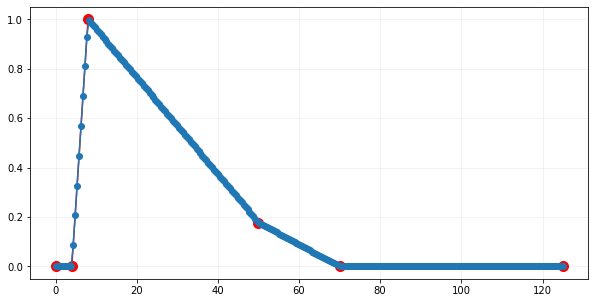

In [9]:
# Get amplitude from power.
P = [0, -15]
a1, a2 = map(lambda p: 10**(p/20), P)

# Set up linear interpolation.
x  = np.linspace(0, nyquist, 10*N)
xp = [  0.,   4.,  8.,  50.,  70., nyquist]
fp = [0, 0, a1, a2, 0, 0 ]

# Spectrum.
W = np.interp(x, xp, fp)

# Plot.
plt.figure(figsize=(10, 5))
plt.plot(xp, fp, 'ro-', ms=10)
plt.plot(x, W, 'o-')
plt.grid('k', alpha=0.2)

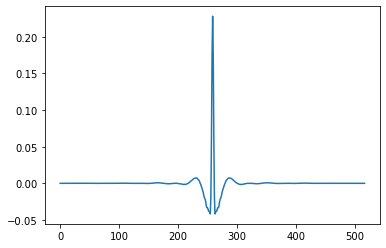

In [10]:
w = np.fft.fftshift(np.fft.irfft(W))

plt.plot(w)

## Implementation

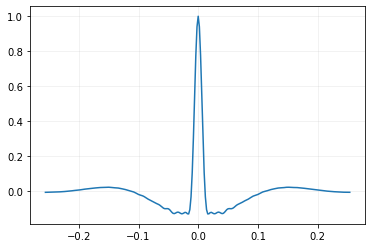

In [12]:
def normalize(data):
    return data / np.amax(abs(data))

def coloured_ormsby(duration, dt, f, P=None):
    """
    Non-white Ormsby, with arbitary amplitudes.
    
    Can use as many points as you like. The power of f1 and f4 is assumed to be 0,
    so you only need to provide p2 and p3 (the corners). (You can actually provide
    as many f points as you like, as long as there are n - 2 matching p points.)
    """
    # Default to 
    if P is None:
        P = [0, 0]

    # Set up.
    fs = 1 / dt
    fN = fs // 2
    n = int(duration / dt)
    a = map(lambda p: 10**(p/20), P)  # Raises ValueError.

    # Linear interpolation of points.
    x  = np.linspace(0, int(fN), int(10*n))
    xp = [  0.] + list(f) +  [fN]
    fp = [0., 0.] + list(a) + [0., 0.]
    W = np.interp(x, xp, fp)

    # Compute inverse FFT.
    w_ = np.fft.fftshift(np.fft.irfft(W))
    t = np.arange(-duration/2, duration/2, dt)
    L = int(w_.size // 2)
    w = normalize(w_[L-n//2:L+n//2])

    return w, t


w, t = coloured_ormsby(duration=0.512, dt=0.002, f=[3.,  6.,  50.,  70.], P=[0, -15])

plt.plot(t, w)
plt.grid('k', alpha=0.2)

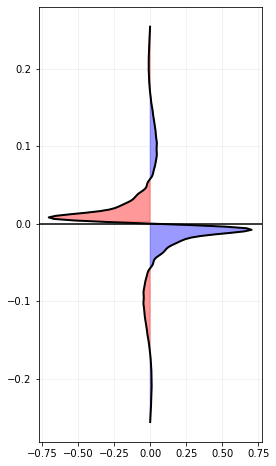

In [13]:
import bruges as bg

w90 = bg.filters.rotate_phase(w, 90, degrees=True)

plt.figure(figsize=(4, 8))
plt.plot(w90, t, 'k', lw=2)
plt.fill_betweenx(t, w90, 0, where=w90<0, color='r', alpha=0.4)
plt.fill_betweenx(t, w90, 0, where=w90>0, color='b', alpha=0.4)
plt.grid('k', alpha=0.2)
plt.axhline(0, color='k')
plt.show()

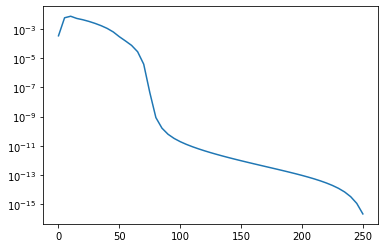

In [15]:
from scipy.signal import welch

plt.semilogy(*welch(w, fs=500, nperseg=100, scaling='spectrum'))

## Compare to original Ormsby implementation

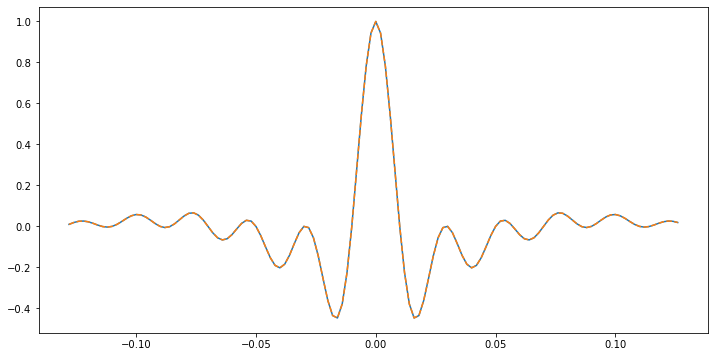

In [16]:
ormc, tc = coloured_ormsby(duration=0.256, dt=0.002, f=[5,  10,  40,  45])
orms, ts = bg.filters.ormsby(duration=0.256, dt=0.002, f=[5,  10,  40,  45], return_t=True)

np.testing.assert_allclose(tc, ts)
np.testing.assert_allclose(ormc, orms, atol=1e-4) # Pretty close...

plt.figure(figsize=(12, 6))
plt.plot(tc, ormc)
plt.plot(ts, orms, '--')

How close are they?

In [17]:
orms - ormc

array([ 1.04898189e-05,  1.23574199e-05,  1.25654920e-05,  1.10180874e-05,
        8.05669854e-06,  4.38543129e-06,  9.01611927e-07, -1.52738004e-06,
       -2.28507508e-06, -1.16763538e-06,  1.55687765e-06,  5.20936057e-06,
        8.86745583e-06,  1.15989008e-05,  1.27011028e-05,  1.18848483e-05,
        9.35356364e-06,  5.75606600e-06,  2.02349157e-06, -8.68515050e-07,
       -2.15128210e-06, -1.46304399e-06,  1.05495583e-06,  4.79172185e-06,
        8.82105211e-06,  1.21376759e-05,  1.39139725e-05,  1.37108771e-05,
        1.15885383e-05,  8.08841974e-06,  4.09194890e-06,  5.92722025e-07,
       -1.55862628e-06, -1.87117663e-06, -3.36839001e-07,  2.57083340e-06,
        6.02058634e-06,  9.03723178e-06,  1.07498107e-05,  1.06107369e-05,
        8.53081601e-06,  4.89719939e-06,  4.71430916e-07, -3.80501980e-06,
       -7.04760845e-06, -8.64811847e-06, -8.42221747e-06, -6.64960319e-06,
       -3.99838409e-06, -1.35399266e-06,  4.04039488e-07,  6.22164621e-07,
       -9.63808116e-07, -

(-0.0001, 0.0001)

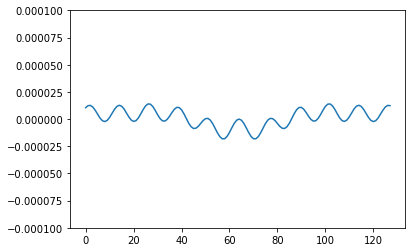

In [23]:
plt.plot(orms - ormc)
plt.ylim(-1e-4, 1e-4)